In [1]:
import arviz as az
import matplotlib
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano as T
import theano.tensor as tt

from matplotlib import pyplot as plt
from numpy.random import default_rng

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

np.set_printoptions(precision=3, suppress=True)
RANDOM_SEED = 314159
np.random.seed(RANDOM_SEED)

Factor analysis is a widely used probabilistic model for identifying low-rank structure in multivariate data as encoded in latent variables. It is very closely related to principal components analysis, and differs only in the prior distributions assumed for these latent variables. It is also a good example of a linear Gaussian model as it can be described entirely as a linear transformation of underlying Gaussian variates. For a high-level view of how factor analysis relates to other models, you can check out [this diagram](https://www.cs.ubc.ca/~murphyk/Bayes/Figures/gmka.gif) originally published by Ghahramani and Roweis.

To work through a few examples, we'll first generate some data. The data will not follow the exact generative process assumed by the factor analysis model, as the latent variates will not be Gaussian. We'll assume that we have an observed data set with $N$ rows and $d$ columns which are actually a noisy linear function of $k_{true}$ latent variables.

In [3]:
n = 250
k_true = 4
d = 10

The next code cell generates the data via creating latent variable arrays `M` and linear transformation `Q`. Then, matrix product $QM$ is perturbed with additive Gaussian noise controlled by the variance parameter `err_sd`.

In [4]:
err_sd = 2
M = np.random.binomial(1, 0.25, size=(k_true, n))
Q = np.hstack(
    [np.random.exponential(2 * k_true - k, size=(d, 1)) for k in range(k_true)]
) * np.random.binomial(1, 0.75, size=(d, k_true))

rng = default_rng()
Y = np.round(1000 * np.dot(Q, M) + rng.standard_normal(size=(d, n)) * err_sd) / 1000

Because of the way we have generated the data, the covariance matrix expressing correlations between columns of $Y$ will be equal to $QQ^T$. The fundamental assumption of PCA and factor analysis is that $QQ^T$ is not full rank. We can see hints of this if we plot the covariance matrix:

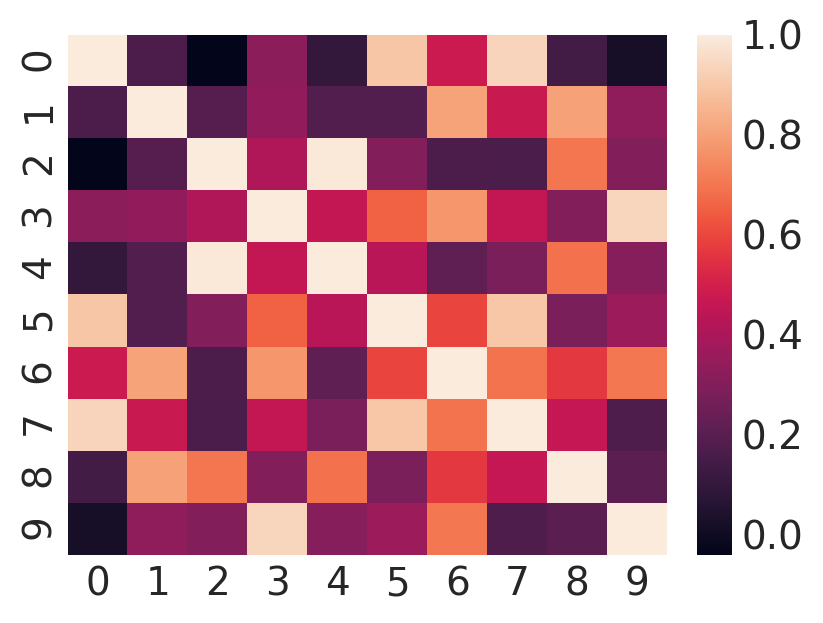

In [5]:
plt.figure(figsize=(4, 3))
sns.heatmap(np.corrcoef(Y));

If you squint long enough, you may be able to glimpse a few places where distinct columns are likely linear functions of each other.

Probabilistic PCA (PPCA) and factor analysis (FA) are a common source of topics in the PyMC3 Disourse cite. The posts linked below handle different aspects of the problem including:
* [Minibatched FA for large datasets](`https://discourse.pymc.io/t/large-scale-factor-analysis-with-minibatch-advi/246`)
* [Handling missing data in FA](`https://discourse.pymc.io/t/dealing-with-missing-data/252`
)
* [Identifiability in FA / PPCA](`https://discourse.pymc.io/t/unique-solution-for-probabilistic-pca/1324/14`
)

The model for factor analysis is the probabilistic matrix factorization

$X_{(d,n)}|W_{(d,k)}, F_{(k,n)} \sim N(WF, \Psi)$

with $\Psi$ a diagonal matrix. Subscripts denote the dimensionality of the matrices. Probabilistic PCA is a variant that sets $\Psi = \sigma^2I$. A basic implementation (taken from [this gist](`https://gist.github.com/twiecki/c95578a6539d2098be2d83575e3d15fe`) is shown in the next cell. Unfortunately, it has undesirable properties for model fitting.

In [6]:
k = 2

coords = {"latent_columns": np.arange(k), "rows": np.arange(n), "observed_columns": np.arange(d)}

with pm.Model(coords=coords) as PPCA:
    W = pm.Normal("W", dims=("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=tt.dot(W, F), sigma=psi, observed=Y)

    trace = pm.sample(
        target_accept=0.9, tune=2000, return_inferencedata=True, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, F, W]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 30 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.45151691448011216, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8354623894699666, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


At this point, there are already several warnings regarding diverging samples and failure of convergence checks. We can see further problems in the trace plot:

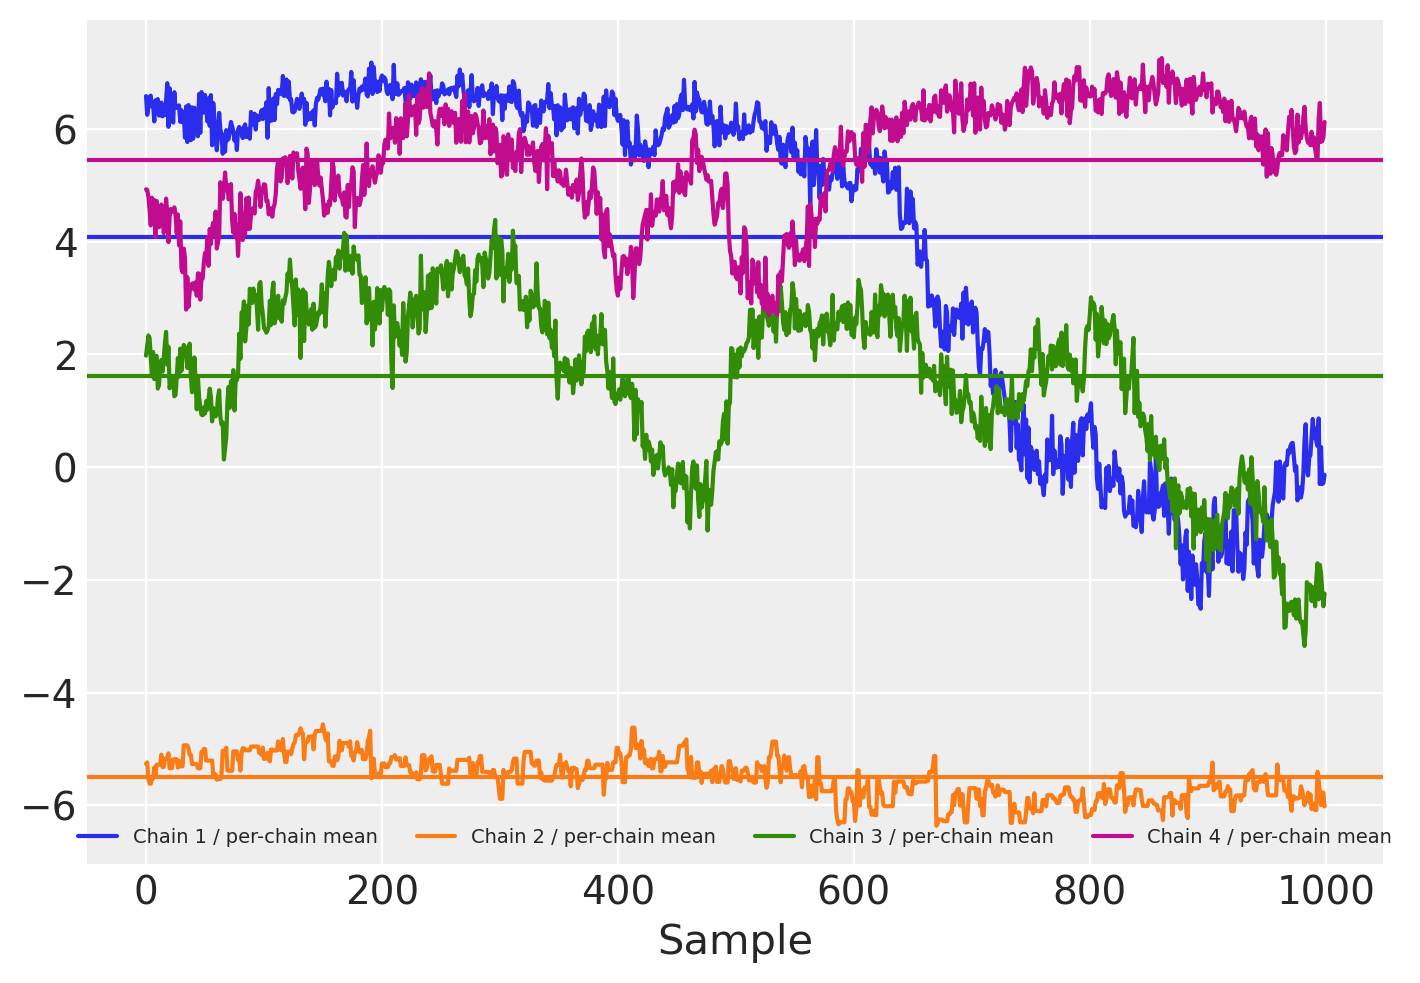

In [7]:
for i in trace.posterior.chain.values:
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    ax = plt.plot(samples, label="Chain {} / per-chain mean".format(i + 1))
    plt.axhline(samples.mean(), color=ax[0].get_color())
plt.legend(ncol=4, loc="lower center", fontsize=7), plt.xlabel("Sample");

The plot above shows posterior estimates for a single entry in the matrix $W$ across four different chains. Each chain appears to have a different sample mean and we can also see that there is a great deal of autocorrelation across chains, manifest as long-range trends over sampling interations. Some of the chains may have divergences as well, lending further evidence to the claim that using MCMC for this model as shown is suboptimal.

One of the primary drawbacks for this model formulation is its lack of identifiability. With this model representation, only the product $WF$ matters for the likelihood of $X$, so $P(X|W, F) = P(X|W\Omega, \Omega^{-1}F)$ for any invertible matrix $\Omega$. While the priors on $W$ and $F$ constrain $|\Omega|$ to be neither too large or too small, factors and loadings can still be rotated, reflected, and/or permuted *without changing the model likelihood*. Expect it to happen between runs of the sampler, or even for the parametrization to "drift" within run, and to produce the highly autocorrelated $W$ traceplot above.

This can be fixed by constraining the form of W to be:
  + Lower triangular
  + Positive with an increasing diagonal
  
We can adapt `expand_block_triangular` to fill out a non-square matrix. This function mimics `pm.expand_packed_triangular`, but while the latter only works on packed versions of square matrices (i.e. $d=k$ in our model, the former can also be used with nonsquare matrices.

In [8]:
def expand_packed_block_triangular(d, k, packed, diag=None, mtype="theano"):
    # like expand_packed_triangular, but with d > k.
    assert mtype in {"theano", "numpy"}
    assert d >= k

    def set_(M, i_, v_):
        if mtype == "theano":
            return tt.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M

    out = tt.zeros((d, k), dtype=float) if mtype == "theano" else np.zeros((d, k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(d, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(d, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out

We'll also define another function which helps create a diagonal positive matrix with increasing entries along the main diagonal.

In [9]:
def makeW(d, k, dim_names):
    # make a W matrix adapted to the data shape
    n_od = int(k * d - k * (k - 1) / 2 - k)
    z = pm.HalfNormal(
        "W_z", 1.0, shape=(k,)
    )  # trick: the cumulative sum of z will be positive increasing
    b = pm.HalfNormal("W_b", 1.0, shape=(n_od,))
    L = pm.Deterministic("W_L", expand_packed_block_triangular(d, k, b, tt.ones(k)))
    W = pm.Deterministic("W", tt.dot(L, tt.diag(tt.extra_ops.cumsum(z))), dims=dim_names)
    return W

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, F, W_b, W_z]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 55 seconds.
The number of effective samples is smaller than 10% for some parameters.


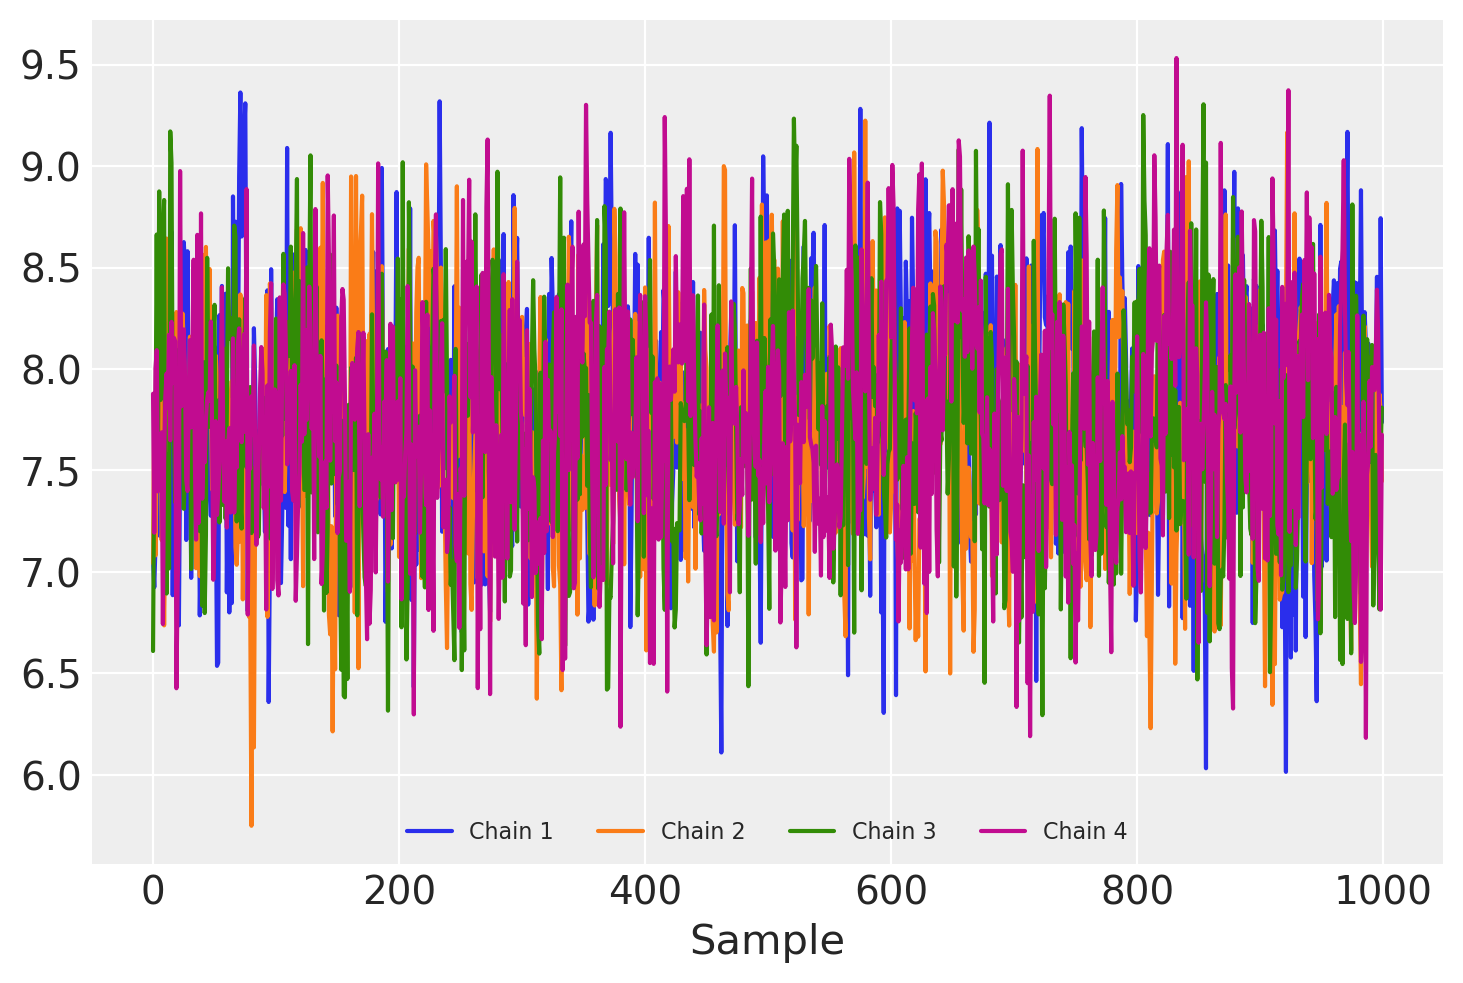

In [10]:
with pm.Model(coords=coords) as PPCA_identified:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    F = pm.Normal("F", dims=("latent_columns", "rows"))
    psi = pm.HalfNormal("psi", 1.0)
    X = pm.Normal("X", mu=tt.dot(W, F), sigma=psi, observed=Y)
    trace = pm.sample(target_accept=0.9, tune=2000, return_inferencedata=True)

for i in range(4):
    samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    plt.plot(samples, label="Chain {}".format(i + 1))

plt.legend(ncol=4, loc="lower center", fontsize=8), plt.xlabel("Sample");

$W$ (and $F$!) now have entries with identical posterior distributions as compared between sampler chains.

Because the $k \times n$ parameters in F all need to be sampled, sampling can become quite expensive for very large `n`. In addition, the link between an observed data point $X_i$ and an associated latent value $F_i$ means that streaming inference with mini-batching cannot be performed.

This scalability problem can be addressed analytically by integrating $F$ out of the model. By doing so, we postpone any calculation for individual values of $F_i$ until later. Hence, this approach is often described as *amortized inference*. However, this fixes the prior on $F$, allowing for no modeling flexibility. In keeping with $F_{ij} \sim N(0, 1)$ we have:

$X|WF \sim \mathrm{MatrixNormal}(WF, \Psi, I), \;\; F_{ij} \sim N(0, 1)$

$X|W \sim \mathrm{MatrixNormal}(0, \Psi + WW^T, I)$

If you are unfamiliar with the matrix normal distribution, you can consider it to be an extension of the multivariate Gaussian to matrix-valued random variates. Then, the between-row correlations and the between-column correlations are handled by two separate covariance matrices specified as parameters to the matrix normal. Here, it simplifies our notation for a model formulation that has marginalized out $F_i$. The explicit integration of $F_i$ also enables batching the observations for faster computation of `ADVI` and `FullRankADVI` approximations.

In [11]:
with pm.Model(coords=coords) as PPCA_scaling:
    W = makeW(d, k, ("observed_columns", "latent_columns"))
    Y_mb = pm.Minibatch(Y.T, 50)  # MvNormal parametrizes covariance of columns, so transpose Y
    psi = pm.HalfNormal("psi", 1.0)
    E = pm.Deterministic("cov", tt.dot(W, tt.transpose(W)) + psi * tt.diag(tt.ones(d)))
    X = pm.MvNormal("X", 0.0, cov=E, observed=Y_mb)
    trace_vi = pm.fit(n=50000, method="fullrank_advi", obj_n_mc=1).sample()

/Users/v7k/anaconda3/envs/gbi_env_py38/lib/python3.8/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


Finished [100%]: Average Loss = 1,756.8


When we compare the posteriors calculated using MCMC and VI, we find that (for at least this specific parameter we are looking at) the two distributions are close, but they do differ in their mean. The MCMC chains all agree with each other but the fullrank ADVI estimate is closer to zero.

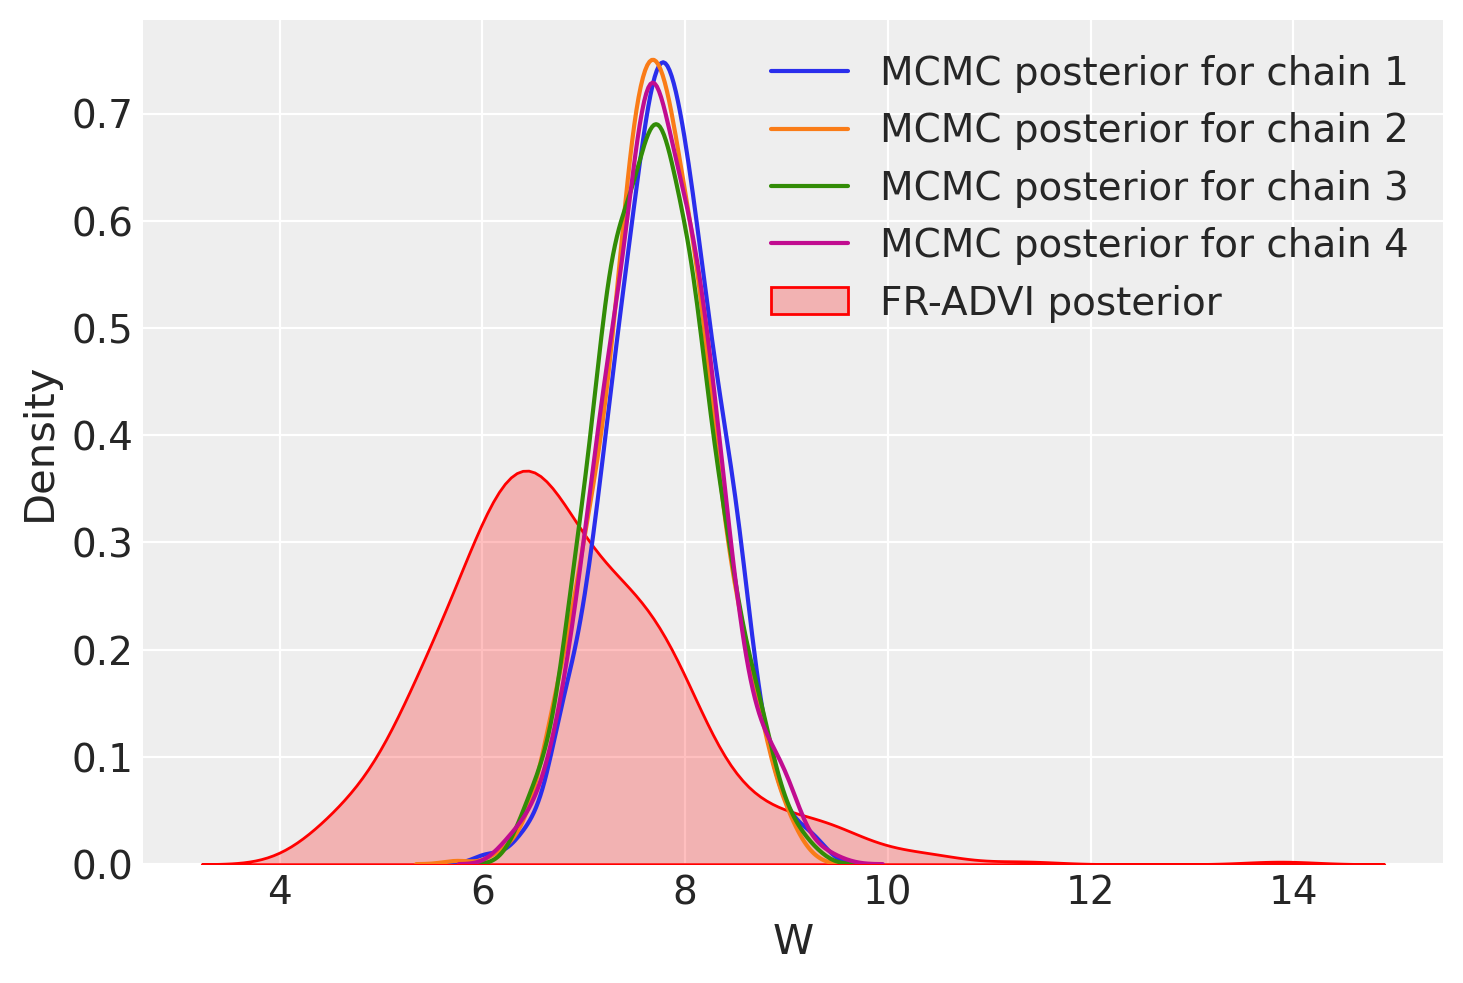

In [12]:
for i in trace.posterior.chain.values:
    mcmc_samples = trace.posterior["W"].sel(chain=i, observed_columns=3, latent_columns=1)
    sns.kdeplot(mcmc_samples, label="MCMC posterior for chain {}".format(i + 1))
sns.kdeplot(trace_vi["W"][:, 3, 1], label="FR-ADVI posterior", shade=True, color="red")
plt.legend();

### Post-hoc identification of F

The matrix $F$ is typically of interest for factor analysis, and is often used as a feature matrix for dimensionality reduction. However, $F$ has been 
marginalized away in order to make fitting the model easier; and now we need it back. This is, in effect, an exercise in least-squares as:

$X|WF \sim N(WF, \Psi)$

$(W^TW)^{-1}W^T\Psi^{-1/2}X|W,F \sim N(F, (W^TW)^{-1})$

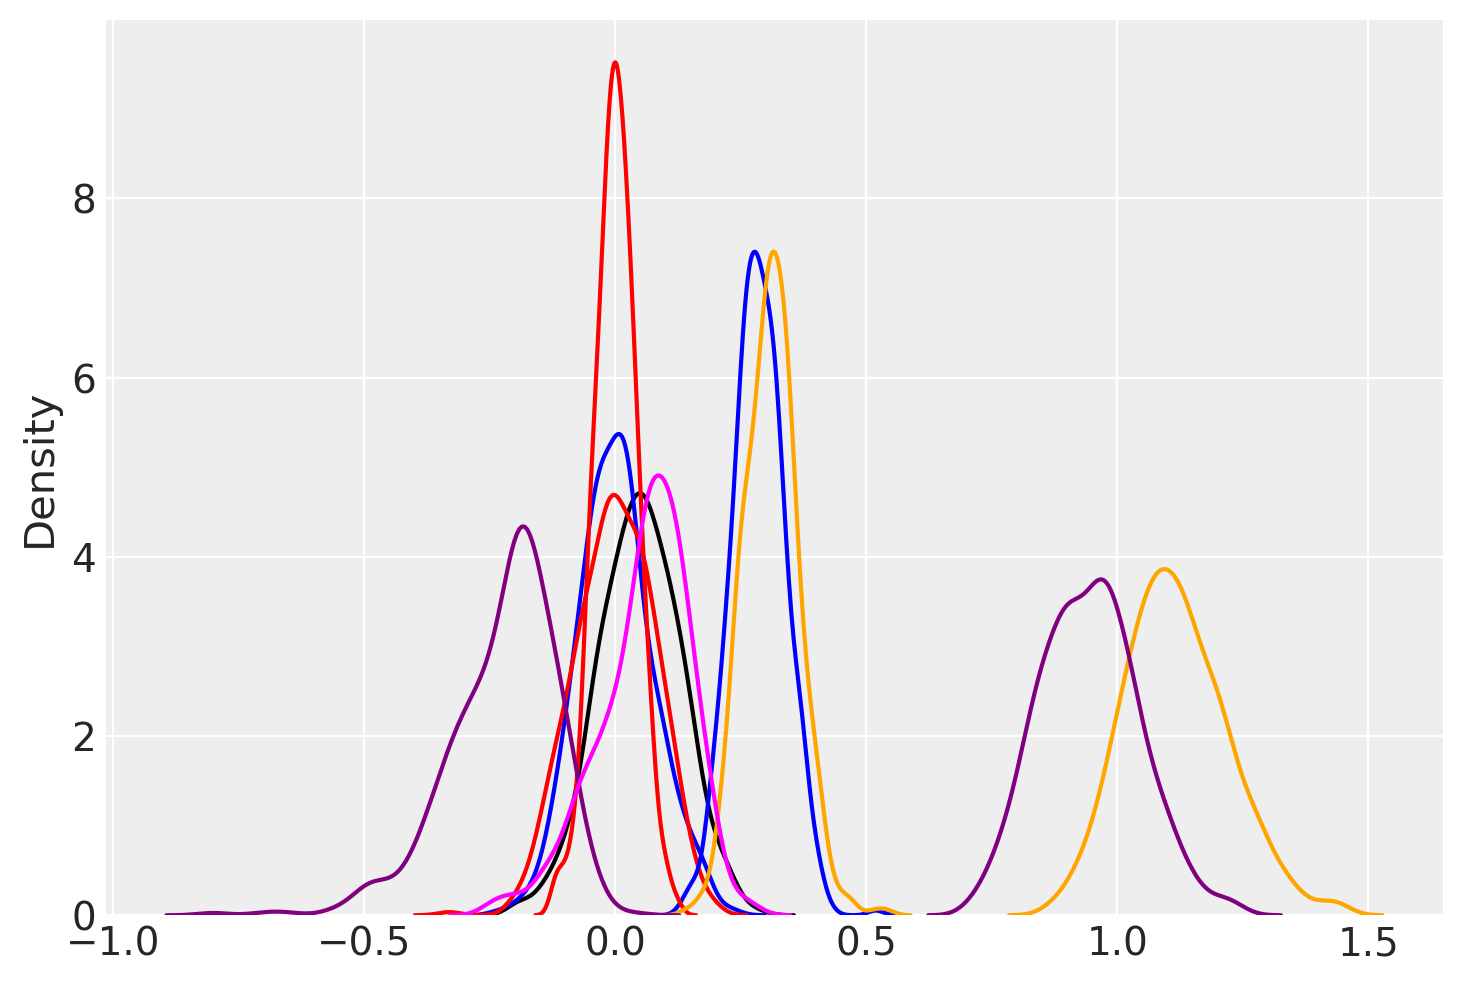

In [13]:
n_samples = len(trace_vi)
F_sampled = np.zeros((n_samples, k, n))

for q in range(n_samples):
    Wq = trace_vi["W"][q, :, :]
    Pq = trace_vi["psi"][q]
    WWq = np.linalg.inv(np.dot(Wq.T, Wq))
    Fq_mu = np.dot(1 / np.sqrt(Pq) * np.dot(WWq, Wq.T), Y)
    WWq_chol = np.linalg.cholesky(WWq)
    F_sampled[q, :, :] = Fq_mu + np.dot(WWq_chol, rng.standard_normal(size=(k, n)))

cols = ["black", "blue", "red", "orange", "purple", "magenta", "green", "yellow"]
for i in range(2):
    for j in range(5):
        sns.kdeplot(F_sampled[:, i, j], color=cols[(i + j) % len(cols)]);

* This notebook was written by [chartl](https://github.com/chartl) on May 6, 2019 and updated by [Christopher Krapu](https://github.com/ckrapu) on April 4, 2021. 

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Apr 04 2021

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.20.0

numpy     : 1.19.2
seaborn   : 0.11.1
arviz     : 0.11.0
theano    : 1.1.0
scipy     : 1.6.1
pymc3     : 3.11.0
matplotlib: 3.3.4

Watermark: 2.2.0

